<a href="https://colab.research.google.com/github/hrushikute/DataAnalytics/blob/master/NLP_introduction_to_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequence of text  or speech)
Another common term for NLP problems is sequence to sequence problems (seq2seq).

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-0d313d1f-5de9-16ed-18e3-4af7e8eb84a0)


## Get Helper functions

In [2]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import Series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-10-26 07:11:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-26 07:11:16 (79.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get text dataset

The dataset we are going to use is Kaggles introduction to NLP dataset (test samples of Tweets labelled a disaster or not disaster).

See orginal source : https://www.kaggle.com/c/nlp-getting-started/overview

In [3]:
! wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2021-10-26 07:11:18--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 142.250.159.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2021-10-26 07:11:18 (89.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [4]:
# Unzip the data

unzip_data('nlp_getting_started.zip')

## Visualize a text dataset 

In [5]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [6]:
## Shuffle the training data.
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
#How many examples of each class
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Visualising the random data samples
import random

random_index = random.randint(0,len(train_df)-5)

for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target : {target} ","(read disaster)" if target> 0 else "(not a real disastee)")
  print (f"Text : \n{text}\n")
  print (f"------\n")


Target : 1  (read disaster)
Text : 
More homes razed by Northern Calif. wildfire http://t.co/u52RW9Ji2r #sandiego http://t.co/GX75w3q9Ye

------

Target : 0  (not a real disastee)
Text : 
Louis Vuitton CultSierre Monogram Shoulder Bag Cross Body Bag  http://t.co/mUf5cZQjrL http://t.co/SsLT8ESMhY

------

Target : 1  (read disaster)
Text : 
#breaking #news Global precipitation measurement satellite captures 3-D image of Typhoon Soudelor - @NASAHurricane http://t.co/20DNcthr4D

------

Target : 1  (read disaster)
Text : 
I was taught at school in the 1970s that piracy slavery and suicide-bombing were purely historical. No one then expected them to re-occur

------

Target : 1  (read disaster)
Text : 
Petition/No Medals for 1890 Massacre Justice for Wounded Knee Killings of Native Americans! http://t.co/UilPg8i1ev http://t.co/m9pXTo2kwW

------



# Split the data into trainig and validation sets

In [11]:
from sklearn.model_selection import train_test_split


In [12]:
# Use train_test_split to split training data into training and validation sets


train_sentences, val_sentences, train_label, val_label = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                          train_df_shuffled["target"].to_numpy(),
                                                                          test_size = 0.1, # use 10% of training data as validation data
                                                                          random_state = 42)
len(train_sentences), len(val_sentences),len(train_label),len(val_label)

(6851, 762, 6851, 762)

In [13]:
len(train_df_shuffled)

7613

In [14]:
# check first few samples from training  samples

train_sentences[:10] , train_label[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

# We need to convert the the text data into numbers

When dealing with a text problem , one of the first things we will have to do before we can build a model is to convert our test to numbers.

There are few ways to do this , namely :

* Tokenization - direct mapping of token (a token could be a word or a character ) to number.

* Embedding - Create a matix  of feature vector for each token (the size of the feature vector can be defined and this embedding  can be learned )

## Text vectorization  (tokenization)



In [15]:
import tensorflow as tf

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use deafult text vectorization Parameter

text_vectorizer = TextVectorization(max_tokens= 1000,# How many words in vocabulary (automatically add <OOV> out of vocabulary)
                                    standardize = 'lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None,# create a group of n-words?
                                    output_mode='int', # this is how to map text to numbers
                                    output_sequence_length=None,# Automatically pads each squence to longest sequnce
                                    pad_to_max_tokens=True)


In [16]:
# Find the average number of tokens (words) in the training tweets.
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
# Set up text Vectorization variables.

max_vocab_length = 10000 #max number of words to have in put vocabulary
max_length = 15 # max length of our sequnces(Eg: How many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [18]:
# Fit the text vectorizer to training dataset

text_vectorizer.adapt(train_sentences)

In [19]:
# Create a sample sentence and tokensize it.

sample_sentence = "There is a cloud burst on my street"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  74,    9,    3, 3100, 2174,   11,   13,  698,    0,    0,    0,
           0,    0,    0,    0]])>

In [20]:
# Choose a random sentence from a training dataset and tokenize it

random_sentence = random.choice(train_sentences)
print(f"Original Text : \n{random_sentence}\
\n\nVectorized version : \n {text_vectorizer([random_sentence])}")

Original Text : 
Pakistan Supreme Court OKs Military Courts to Try Civilians: The Supreme Court ruling would empower the milita... http://t.co/v0nf1Uc1OW

Vectorized version : 
 [[ 811 2666 1310 4999  223 5903    5  831 1699    2 2666 1310 8924   78
     1]]


In [21]:
# Ge tthe unique words in vocabulary

words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words from traing data sets

top_5_words = words_in_vocab[:5] # get most common words from vocabulary of training data set.

bottom_5_words = words_in_vocab[-5:] #get least common words

print(f"Total number of words :{len(words_in_vocab)}")
print(f"\nTop 5 words : {top_5_words}\
        \nBottom 5 words: {bottom_5_words}\n")

Total number of words :10000

Top 5 words : ['', '[UNK]', 'the', 'a', 'in']        
Bottom 5 words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']



# Creating an Embedding using Embedding layer

To make out embedding we are going to use TensorFlow Embedding layer

src : https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding


The parameters we care most in our mebedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = size of the output embedding vector, Eg: A value of 100 would mean each token gets represented by a vector 100 long
* `input_lenght` = length of the sequences being passed to embedding layer

In [22]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim = max_vocab_length, #set input shape
                             output_dim=128,
                             input_length=max_length # how long is each input
                             )

In [23]:
embedding #Turns positive integers (indexes) into dense vectors of fixed size

In [24]:
random_sentence=random.choice(train_sentences)
sample_embed = embedding(text_vectorizer([random_sentence]))
print(f"Original Text : {random_sentence}\
      \n\n Embedded version :{sample_embed}")

#

Original Text : The MF Life is a vocal and lyrical bomb. Saw her live this summer. AMAZING vocalist. RT @THEmale_madonna: Melanie Fiona is so slept on ??      

 Embedded version :[[[-0.01408533  0.02390658  0.04191667 ...  0.04425095 -0.04011301
   -0.03638389]
  [-0.0438265   0.02014929  0.02085842 ...  0.03074259 -0.01577631
    0.02843796]
  [ 0.01386497  0.01252634  0.01338248 ... -0.03201381  0.03366183
    0.04447067]
  ...
  [-0.0061443   0.00511656  0.04932019 ...  0.02530751 -0.00238049
   -0.04319514]
  [ 0.03819169  0.00037203 -0.04821325 ...  0.03864701  0.02041365
    0.01883342]
  [-0.00338168 -0.00024106  0.04721243 ... -0.04091935 -0.01934208
    0.0211602 ]]]


In [25]:
# check out single token's embeding

sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.01408533,  0.02390658,  0.04191667, -0.01826144, -0.03595863,
        -0.00538269,  0.04793188,  0.02273002,  0.00541326,  0.02716768,
        -0.02664664,  0.02596308, -0.00637597,  0.00173723, -0.00748213,
         0.04368026, -0.01567693, -0.01209415,  0.00674624,  0.01868064,
         0.00215076, -0.03314023,  0.03184709, -0.0333452 , -0.02435501,
         0.03831042, -0.01694755,  0.04933849, -0.02450408, -0.0160719 ,
         0.00158236, -0.01150789,  0.0040152 , -0.00033044, -0.00885342,
         0.00119586, -0.0013374 , -0.00984311,  0.03788567,  0.00017434,
        -0.04412526,  0.0249381 , -0.03212609, -0.0058884 ,  0.0222454 ,
         0.01082582, -0.04540547,  0.03764273, -0.03687175,  0.02862133,
        -0.0188391 ,  0.02428491,  0.00754404,  0.0456803 ,  0.03902197,
        -0.03215355,  0.01926166, -0.03230929,  0.02768058,  0.00589984,
         0.04162102, -0.03962003,  0.00048512, -0.03862906,  0.02891859,
  

## Modelling a text dataset and running experiments through it.

---
Experiment# -- >   Model

0   -- > Navie Bayes with TF-IDF encoder(baseline)

1   -- > Feed Forward neural network (dense model)

2   -- > LSTM(RNN)

3   -- > GRU(RNN)

4   -- > Bi-Directional-LSTM(RNN)

5   -- > 1D Convolututional Newral Network

6   -- > TensorFlow Hub Pretrained Feature Extractor

7   -- > TensorFlow Hub Pretrained Freture Extractor (10% of data)







##Steps in Modelling
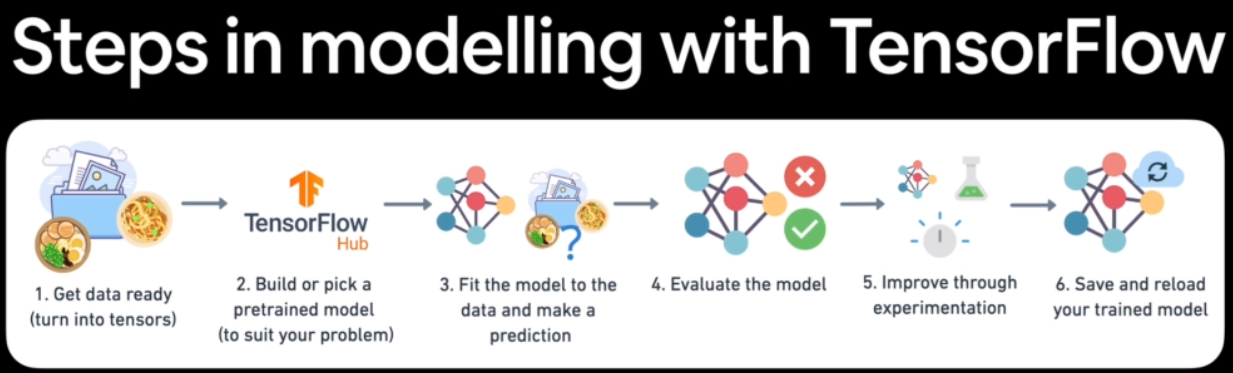


## Model 0 --> Navie Bayes with TF-IDF encoder(baseline) 
src : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

As with all machine learining modelling experiments, it's important to create a baseline model so we get a benchmark for future experiments. 

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Build a model
model_0 = Pipeline([
   ( "tfidf", TfidfVectorizer()),
   ( "classifier",MultinomialNB() )
])

# Fit the model

model_0.fit(train_sentences,train_label)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [27]:
# Evaluate the model_0 or a baseline model

model_0_score = model_0.score(val_sentences, val_label)

print(f"Accuracy of baseline model is : {model_0_score *100:.2f}%")


Accuracy of baseline model is : 79.27%


In [28]:
#Predict the data and create a csv out of it
prediction = model_0.predict(test_df['text'])

import pandas as pd
def create_csv_output(X,y):
    output=pd.DataFrame(data={"id":X,"target":y})
    output.to_csv("results.csv",index=False,quoting=3)

create_csv_output(test_df['id'],prediction)

## Create an evaluation function for our model experiments

Lets create function to compare out model's prediction with the truth labels using following metrics

* Accuracy
* Precision
* Recall
* F1 Score

In [29]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  '''

  Calcuates model accuracy, precision, recall, and f1 score of a binary classification model.

  '''
  # Calculate model accuracy

  model_accuracy = accuracy_score(y_true, y_pred)*100

  # Calculate model Precision recall  & f1 scores
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {
                  "accuracy":model_accuracy,
                   "precision": model_precision,
                   "recall":model_recall,
                   "f1_score": model_f1
  }

  return model_results

baseline_predict = model_0.predict(val_sentences)
baseline_results = calculate_results(val_label, baseline_predict)

print(baseline_results)

{'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1_score': 0.7862189758049549}


## Building Model 1 : Simple Dense Model

In [30]:
# Create a tensorboard CallBack(need to create a new one for each model)

from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs

SAVE_DIR = "model_logs"

from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string) # inputs are 1 dimensional strings
x = text_vectorizer(inputs) # trun input text into numbers
x = embedding(x) # create an embedding of numberised inputs
x = layers.GlobalAveragePooling1D()(x) # Condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x) # Create a output layer, want binary classification hence sigmoid fucntion

model_1 = tf.keras.Model(inputs,outputs, name = "model_1_dense")

In [31]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Compile the model 

model_1.compile (loss="binary_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

In [33]:
# Fit the model

model_1_history = model_1.fit(x=train_sentences,
                              y=train_label,
                              epochs=10,
                              validation_data= (val_sentences,val_label),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="model_1_dense")]
                              )

Saving TensorBoard log files to: model_logs/model_1_dense/20211026-071126
Epoch 1/10
215/215 [==============================] - 5s 9ms/step - loss: 0.6133 - accuracy: 0.6885 - val_loss: 0.5389 - val_accuracy: 0.7441
Epoch 2/10
215/215 [==============================] - 1s 7ms/step - loss: 0.4419 - accuracy: 0.8202 - val_loss: 0.4694 - val_accuracy: 0.7861
Epoch 3/10
215/215 [==============================] - 1s 7ms/step - loss: 0.3470 - accuracy: 0.8622 - val_loss: 0.4579 - val_accuracy: 0.7848
Epoch 4/10
215/215 [==============================] - 1s 7ms/step - loss: 0.2835 - accuracy: 0.8913 - val_loss: 0.4645 - val_accuracy: 0.7848
Epoch 5/10
215/215 [==============================] - 1s 7ms/step - loss: 0.2370 - accuracy: 0.9126 - val_loss: 0.4810 - val_accuracy: 0.7782
Epoch 6/10
215/215 [==============================] - 1s 7ms/step - loss: 0.2018 - accuracy: 0.9299 - val_loss: 0.5056 - val_accuracy: 0.7822
Epoch 7/10
215/215 [==============================] - 1s 7ms/step - loss: 

In [34]:
pred_val_probab = model_1.predict(val_sentences)
pred_val_probab
pred_val_probab.shape

# create_csv_output(test_df['id'],prediction)

(762, 1)

In [35]:
# convert model prediction probabilites to label format
val_prediction = tf.squeeze(tf.round(pred_val_probab))
val_prediction[:20]



<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [36]:
# calculate the result

model_1_results =calculate_results(val_label,val_prediction)
model_1_results


{'accuracy': 76.9028871391076,
 'f1_score': 0.7671875324347506,
 'precision': 0.7701356893081864,
 'recall': 0.7690288713910761}

In [37]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1_score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [38]:
# Lets check did we improved compared to baseline model
import numpy as np

np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [39]:
# That means our experiment with simple dense layer was not better than baseline.

##Visualising learned  embeddings 

In [40]:
# Get the vocalbulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [41]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Get the weight matrix of embedding layer
# these are the numberical representation of each token in our training data

embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights

print(embed_weights.shape)

(10000, 128)


Now we  have got the embedding matrix our model has learned to represent our tokens, lets see 
how we can visualise it.

To do so TensorFlow has handy tool called projector : https://projector.tensorflow.org/ 

And tensorflow has great guide on word embeddings : https://www.tensorflow.org/text/guide/word_embeddings


In [43]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [44]:
## Download the files in order to upload it to projector.

# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## Recurrent neural network

RNNs are useful for sequence data

The premise of recurrent neural Netwoek is to use the representation of
previous input to aid the representation of a later input.



## Model 2 : LSTM 

LSTM  = Long short term Memory (one of the most ppopular LSTM cells)

Our RNN structure will typically look like

```
Input text --> Tokenize --> Embedding --> layers (RNNs / dense) --> Output (label probailities)

```

In [45]:
# Create an LSTM model

from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x=text_vectorizer(inputs)
x=embedding(x)

#x=layers.LSTM(units=64, return_sequences=True) # When you are stacking RNN cells together, you need to retrun_sequences=True
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs=layers.Dense(1,activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs,outputs, name="model_2_LSTM")


In [46]:
#Get summary 

model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,333,633
Trainable params: 1,333,633
Non-trainable params: 0
____________________________________________

In [47]:
# Compile the model 

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [48]:
#Fit a model

model_2_history = model_2.fit(train_sentences, train_label,epochs=10,
                              validation_data=(val_sentences,val_label),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20211026-071150
Epoch 1/10
215/215 [==============================] - 8s 14ms/step - loss: 0.1477 - accuracy: 0.9550 - val_loss: 0.7328 - val_accuracy: 0.7690
Epoch 2/10
215/215 [==============================] - 2s 10ms/step - loss: 0.0862 - accuracy: 0.9672 - val_loss: 0.8725 - val_accuracy: 0.7756
Epoch 3/10
215/215 [==============================] - 2s 10ms/step - loss: 0.0782 - accuracy: 0.9692 - val_loss: 0.8107 - val_accuracy: 0.7677
Epoch 4/10
215/215 [==============================] - 2s 10ms/step - loss: 0.0663 - accuracy: 0.9737 - val_loss: 1.0514 - val_accuracy: 0.7677
Epoch 5/10
215/215 [==============================] - 2s 10ms/step - loss: 0.0593 - accuracy: 0.9743 - val_loss: 1.1616 - val_accuracy: 0.7651
Epoch 6/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0492 - accuracy: 0.9778 - val_loss: 1.4189 - val_accuracy: 0.7625
Epoch 7/10
215/215 [==============================] - 2s 10ms/step - 

In [49]:
# Check the results against baseline

pred_val_probab = model_2.predict(val_sentences)
pred_val_probab
pred_val_probab.shape

# convert model prediction probabilites to label format
val_prediction = tf.squeeze(tf.round(pred_val_probab))
val_prediction[:20]

model_2_results=calculate_results(val_label,val_prediction)
model_2_results

{'accuracy': 76.24671916010499,
 'f1_score': 0.7607595644846901,
 'precision': 0.7631352147335341,
 'recall': 0.7624671916010499}

In [50]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1_score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 3 - GRU

Gated Recurrent unit -- it is similar to LSTM but with less parameters.

In [51]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x=text_vectorizer(inputs)
x=embedding(x)
print(x.shape)
x=layers.GRU(units=64, return_sequences=True)(x) # When you are stacking RNN cells together, you need to retrun_sequences=True
print(x.shape)
x = layers.LSTM(64,return_sequences=True)(x)
print(x.shape)
x = layers.GRU(64)(x)
print(x.shape)
x = layers.Dense(64, activation="relu")(x)
print(x.shape)
outputs=layers.Dense(1,activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs,outputs, name="model_3_GRU")

(None, 15, 128)
(None, 15, 64)
(None, 15, 64)
(None, 64)
(None, 64)


In [52]:
# Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
)

In [53]:
model_3_history = model_3.fit (train_sentences,
                               train_label,epochs=10,
                               validation_data=(val_sentences, val_label),
                               callbacks=[create_tensorboard_callback(SAVE_DIR,"model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20211026-071235
Epoch 1/10
215/215 [==============================] - 11s 28ms/step - loss: 0.1073 - accuracy: 0.9629 - val_loss: 1.1542 - val_accuracy: 0.7638
Epoch 2/10
215/215 [==============================] - 4s 20ms/step - loss: 0.0498 - accuracy: 0.9772 - val_loss: 0.9771 - val_accuracy: 0.7690
Epoch 3/10
215/215 [==============================] - 4s 20ms/step - loss: 0.0442 - accuracy: 0.9800 - val_loss: 1.3463 - val_accuracy: 0.7717
Epoch 4/10
215/215 [==============================] - 4s 19ms/step - loss: 0.0465 - accuracy: 0.9774 - val_loss: 1.3876 - val_accuracy: 0.7638
Epoch 5/10
215/215 [==============================] - 4s 19ms/step - loss: 0.0420 - accuracy: 0.9810 - val_loss: 1.4480 - val_accuracy: 0.7717
Epoch 6/10
215/215 [==============================] - 4s 20ms/step - loss: 0.0405 - accuracy: 0.9794 - val_loss: 1.8457 - val_accuracy: 0.7717
Epoch 7/10
215/215 [==============================] - 4s 20ms/step -

In [54]:
# Get Model Prediction probabilities

model_3_pred_prob = model_3.predict(val_sentences)
model_3_pred_prob[:10]

array([[6.6210735e-03],
       [6.1757493e-01],
       [9.9990761e-01],
       [1.6368575e-01],
       [3.4842974e-06],
       [9.9933904e-01],
       [9.6420979e-01],
       [9.9994588e-01],
       [9.9988842e-01],
       [9.9918920e-01]], dtype=float32)

In [55]:
# Covert the probabilities to binary output
model_3_pred = tf.squeeze(tf.round(model_3_pred_prob))
model_3_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [56]:
model_3_results = calculate_results(y_true=val_label,
                                    y_pred=model_3_pred)
model_3_results

{'accuracy': 77.16535433070865,
 'f1_score': 0.7691811868378113,
 'precision': 0.7741380916586217,
 'recall': 0.7716535433070866}

## Model 4 : Bidirectional RNN



In [57]:
## Build a bidirectional Model

from tensorflow.keras import layers

inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)

x = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs=layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs,outputs,name="model_4_bidirectional")


In [58]:
# Compile the model

model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [59]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,453,441
Trainable params: 1,453,441
Non-trainable params: 0
___________________________________

In [60]:
 model_4.fit(train_sentences, train_label,epochs=10,validation_data=(val_sentences, val_label),callbacks=[create_tensorboard_callback(SAVE_DIR,"model_4_bidirectional")])


Saving TensorBoard log files to: model_logs/model_4_bidirectional/20211026-071404
Epoch 1/10
215/215 [==============================] - 14s 35ms/step - loss: 0.0865 - accuracy: 0.9723 - val_loss: 1.0290 - val_accuracy: 0.7690
Epoch 2/10
215/215 [==============================] - 5s 24ms/step - loss: 0.0407 - accuracy: 0.9799 - val_loss: 1.1890 - val_accuracy: 0.7638
Epoch 3/10
215/215 [==============================] - 5s 24ms/step - loss: 0.0358 - accuracy: 0.9799 - val_loss: 1.5379 - val_accuracy: 0.7703
Epoch 4/10
215/215 [==============================] - 5s 24ms/step - loss: 0.0330 - accuracy: 0.9819 - val_loss: 1.6398 - val_accuracy: 0.7703
Epoch 5/10
215/215 [==============================] - 5s 24ms/step - loss: 0.0359 - accuracy: 0.9816 - val_loss: 1.7110 - val_accuracy: 0.7730
Epoch 6/10
215/215 [==============================] - 5s 24ms/step - loss: 0.0397 - accuracy: 0.9804 - val_loss: 1.5563 - val_accuracy: 0.7546
Epoch 7/10
215/215 [==============================] - 5s 24

In [61]:
# Get the validation probabilities

model_4_pred_probab = model_4.predict(val_sentences)
model_4_pred_probab[:10]

array([[1.9244594e-03],
       [8.0250001e-01],
       [9.9998367e-01],
       [3.2005173e-01],
       [6.9176085e-06],
       [9.9963760e-01],
       [6.2621957e-01],
       [9.9999523e-01],
       [9.9999082e-01],
       [9.9985731e-01]], dtype=float32)

In [62]:
# Get prediction probabilities converted to binary output to match the label
model_4_pred = tf.squeeze(tf.round(model_4_pred_probab))
model_4_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [63]:
# Get the results
model_4_results = calculate_results(y_true=val_label,
                                    y_pred=model_4_pred)
model_4_results

{'accuracy': 76.50918635170603,
 'f1_score': 0.7635213723925918,
 'precision': 0.7656343373801384,
 'recall': 0.7650918635170604}

In [64]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1_score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Convolution Neural Networks for Text (and other type if Sequnces)

We have used CNNs for images but images are typically 2D(height x width)...
however , out text data is 1D.

The typical structure of Convolution 1D model for sequence(in our case, text)

```
Input -->(text) --> Tokenization --> Embedding --> layer(s) (Conv1D + Pooling) --> outputs (class probabilites)
```

## Model 5 : Conv1D 


In [65]:
# Test out our Embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence in to embedding.
conv_1d = layers.Conv1D(filters=32,# hidding units in conv_1D 
                        kernel_size =5,
                        activation="relu",
                        padding = "valid")

conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output =max_pool(conv_1d_output) # equivalent to `get the most import feature'

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [66]:
# Create 1 -d imensional convolutionlayer to model sequence
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x =embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation="relu",
                  strides=1,
                  padding="valid"
                  )(x)
x = layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile the model

model_5.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_5.summary()


Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [68]:
# Fit the model 

model_5_history = model_5.fit(train_sentences,train_label,
                              epochs=10, validation_data=(val_sentences,val_label),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,"Conv1D")] )
model_5_history

Saving TensorBoard log files to: model_logs/Conv1D/20211026-071632
Epoch 1/10
215/215 [==============================] - 4s 11ms/step - loss: 0.1089 - accuracy: 0.9638 - val_loss: 1.0251 - val_accuracy: 0.7625
Epoch 2/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0646 - accuracy: 0.9745 - val_loss: 1.1610 - val_accuracy: 0.7612
Epoch 3/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0540 - accuracy: 0.9784 - val_loss: 1.1690 - val_accuracy: 0.7520
Epoch 4/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0496 - accuracy: 0.9783 - val_loss: 1.2151 - val_accuracy: 0.7559
Epoch 5/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0464 - accuracy: 0.9791 - val_loss: 1.3081 - val_accuracy: 0.7559
Epoch 6/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0435 - accuracy: 0.9807 - val_loss: 1.3476 - val_accuracy: 0.7493
Epoch 7/10
215/215 [==============================] - 2s 7ms/step - loss: 0.0443

In [70]:
# Make some predicitons with out ConV1D model

model_5_pred_prob = model_5.predict(val_sentences)
model_5_pred_prob[:10]

array([[6.8440813e-01],
       [9.6674550e-01],
       [9.9997091e-01],
       [5.6646079e-02],
       [1.2101473e-06],
       [9.9957007e-01],
       [9.4476455e-01],
       [9.9998760e-01],
       [9.9999976e-01],
       [9.6760398e-01]], dtype=float32)

In [75]:
# Convert the probabilities to bonary output
model_5_pred = tf.squeeze(tf.round(model_5_pred_prob))
model_5_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [77]:
model_5_result = calculate_results(y_true=val_label, 
                                   y_pred=model_5_pred)
model_5_result

{'accuracy': 75.32808398950131,
 'f1_score': 0.7529546666488423,
 'precision': 0.7528894613723134,
 'recall': 0.7532808398950132}

In [79]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1_score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 6 : Transfer learning  model 
Tensorflow Hub pretrained Snetence Encoder
USE feature extractor : Universal Sentence Extractor.


This model is takne from : https://tfhub.dev/google/universal-sentence-encoder/4


In [80]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,"I love you  "])
print(embed_samples)

tf.Tensor(
[[-0.0589114   0.03995042  0.00297757 ...  0.05531275 -0.04758603
   0.00477128]
 [ 0.03456973 -0.03164847  0.0067515  ... -0.04832187 -0.00310646
  -0.01271175]], shape=(2, 512), dtype=float32)
